In [1]:
import gseapy as gp
from tqdm import tqdm
import json
from pathlib import Path
import scanpy as sc
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('/Users/djemec/data/jepa')
clean_path = data_dir / 'cleaned_replogle_k562.h5ad' # original from https://virtualcellmodels.cziscience.com/dataset/k562-essential-perturb-seq
tokenized_dir = data_dir / 'tokenized'
chunk_size = 10000        # How many cells per .npy file
n_pathways = 1024          # Number of pathway "tokens" per cell
QUANTIZATION_MAX = 20.0   # Cap for outlier clamping (log-normalized expression rarely exceeds this)

## Data Load and Explore

The processed dataset is a single, filtered H5ad file. The .X matrix contains the per-cell gene perturbation counts as provided by the authors.  pertrubation counts are based on CRISPR-based screens with single-cell RNA-sequencing readouts. Within this file, there is unstructured data that contains two sets of differentially expressed genes for each condition, one determined using Wilcoxon rank-sum test and the second by t-test. The unstructured data also contains a mapping between control and target cells for each condition as determined by GEM group and library size (UMI count).

In [3]:
adata = sc.read_h5ad(clean_path)

In [4]:
COL_PERTURBATION = 'perturbation'  # The gene being knocked down
COL_CONTROL_LABEL = 'control' # The label string for control cells
COL_BATCH = 'batch' # Batch column (if available) to match controls/case within same batch

**Cell metadata** (`adata.obs`)

This dataset is a collection of RNA expression counts based on single cell data.  `obs` indexes out the single cell metadata for each cell in the dataset.  Note that when we downloaded the original dataset we filtered the data to only include cells with info on at least 200 genes and info for genes that were detected in at least 3 cells. We can see that this filtering left us with 310385 cells. We then normalized our counts. 

In the cell metadata, 2 columns in particular are important: 
1. `batch` which links control and perturbed cells together
2. `perturbation`which tells us if the cell is a `control` or which gene was knocked out

In [5]:
adata.obs.columns

Index(['batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id',
       'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor',
       'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex',
       'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type',
       'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes'],
      dtype='object')

In [6]:
adata.obs.shape

(310385, 25)

In [7]:
adata.obs.head()

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362,3332
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732,2192
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825,4002
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828,5358
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392,2944


**Batch 27**

Let's look at a single batch.  We'll randomly pick 27 and a few common columns out.  Here we can see that we have a non-targetting/control along with 7736 other perturbation.  Each perturbation in this case is CRISPR knockout of a single gene.  In other datasets you might see introduction of a drug so this can become important as we expand the dataset.  Another key piece to keep in the back of the mind right now is that even our control is cancerous (`disease == chronic myeloid leukemia`).  A couple other userful pieces in the cell metadata is ncounts that tells you the total RNA reads for the cell detected and ngenes that tells us the total non-zero genes identified.  These are great filters 

In [8]:
adata.obs[adata.obs.batch == 27][['batch','gene','disease', 'cancer', 'perturbation', 'perturbation_type', 
                                  'tissue_type','ncounts', 'ngenes', 'nperts']]

,batch,gene,disease,cancer,perturbation,perturbation_type,tissue_type,ncounts,ngenes,nperts
cell_barcode,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,chronic myeloid leukemia,True,NAF1,CRISPR,cell_line,11324.0,3332,1
AAACCCAAGCGTCTGC-27,27,non-targeting,chronic myeloid leukemia,True,control,CRISPR,cell_line,14483.0,3916,0
AAACCCAAGCTGGTGA-27,27,CDAN1,chronic myeloid leukemia,True,CDAN1,CRISPR,cell_line,12906.0,3288,1
AAACCCACACCAGCCA-27,27,KDM8,chronic myeloid leukemia,True,KDM8,CRISPR,cell_line,12976.0,3950,1
AAACCCAGTACAAGCG-27,27,CBLN1,chronic myeloid leukemia,True,CBLN1,CRISPR,cell_line,17600.0,4361,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGGACCTC-27,27,SRBD1,chronic myeloid leukemia,True,SRBD1,CRISPR,cell_line,17689.0,4246,1
TTTGTTGGTTGGACCC-27,27,TIMM23B,chronic myeloid leukemia,True,TIMM23B,CRISPR,cell_line,8720.0,2829,1
TTTGTTGTCACGGGCT-27,27,PPP2R1A,chronic myeloid leukemia,True,PPP2R1A,CRISPR,cell_line,10801.0,3273,1


## 

**Extract Perturbations**

Since we'll need the perturbations later, we'll go ahead and create a dictionary of the perturbations for usage.  This dictionary will allow us to convert the perturbation to a numerical value for easier training. We'll also save this to a file so that if we want to reference it later we can quickly get the information. 

In [9]:
# Prepare Perturbation Dictionary (Str -> Int ID)
all_perturbations = adata.obs[COL_PERTURBATION].unique()
pert_to_id = {p: i for i, p in enumerate(all_perturbations)}
pert_to_id

{'NAF1': 0,
 'BUB1': 1,
 'UBL5': 2,
 'C9orf16': 3,
 'TIMM9': 4,
 'SMG5': 5,
 'ZNF687': 6,
 'MED9': 7,
 'RPL3': 8,
 'PSTK': 9,
 'RNF8': 10,
 'MED1': 11,
 'HNRNPH1': 12,
 'RPL10A': 13,
 'SLC35B1': 14,
 'LIN54': 15,
 'EIF1AX': 16,
 'OR7A17': 17,
 'NUP98': 18,
 'OIP5': 19,
 'ANAPC15': 20,
 'RRM2': 21,
 'N6AMT1': 22,
 'RPS20': 23,
 'WTAP': 24,
 'RIOK2': 25,
 'CIAO1': 26,
 'POP7': 27,
 'EIF3E': 28,
 'MRPS14': 29,
 'MYO1H': 30,
 'control': 31,
 'MRPL2': 32,
 'MED10': 33,
 'TRA2B': 34,
 'PSMC4': 35,
 'NAA38': 36,
 'LENG8': 37,
 'CDAN1': 38,
 'KLC2': 39,
 'CHORDC1': 40,
 'PPP4C': 41,
 'RAB18': 42,
 'TUBGCP2': 43,
 'EIF3M': 44,
 'CADM4': 45,
 'RPL5': 46,
 'TICRR': 47,
 'RPL13': 48,
 'KIF11': 49,
 'ASF1B': 50,
 'CNOT3': 51,
 'WDR36': 52,
 'RPL31': 53,
 'SNAPC3': 54,
 'MED12': 55,
 'PRODH': 56,
 'NBAS': 57,
 'CKAP5': 58,
 'ELP5': 59,
 'ZNF407': 60,
 'SNX15': 61,
 'RPS6': 62,
 'TUBD1': 63,
 'SEC13': 64,
 'EIF4E': 65,
 'H2AFZ': 66,
 'EEF1G': 67,
 'DNAJA1': 68,
 'LSG1': 69,
 'FBXO5': 70,
 'MTOR': 71,

In [10]:
with open(data_dir/'perturbation_map.json', 'w') as f:
            json.dump({str(k): int(v) for k, v in pert_to_id.items()}, f)

**Gene metadata** (`adata.var`)

`var` indexes out the gene metadata that we see expressed in this dataset.  This  corresponds with the columns in `adata.X` and gives you more information on the gene for linking to different datasets or for performing filtering.   Recall that we filtered for genes that were found in at least 3 cells so, if we were to do this manually, we'd use the `ncells` column. We can also see this dataset contains a total of 8563 genes

In [11]:
adata.var.shape

(8563, 15)

In [12]:
adata.var.head()

,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano,ensembl_id,ncounts,ncells,n_cells
gene_name,,,,,,,,,,,,,,,
LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733,ENSG00000237491,42707.0,39082,39082
LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944,ENSG00000228794,79682.0,68732,68732
NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706,ENSG00000188976,613055.0,248759,248759
KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089,ENSG00000187961,37120.0,34277,34277
HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214,ENSG00000188290,77465.0,62316,62316


**Extract Gene Names**   

Since we'll need the genes later one for analysis, i'll go ahead and store the gene names into a variable so that we'll have it easy to call later. 

In [13]:
genes = adata.var_names.tolist()
len(genes)

8563

**Cell X Gene Matrix** (`adata.X`)

`adata.X` is the count matrix (cells × genes) that stores our expression values. We can see that this has as a result 310385 rows (the cells) and 8563 columns (the genes expressed).  The matrix will fill in 0 for the rows not expressed. During preprocessing, we did 2 normalizations on the count frequency: 
1. `sc.pp.normalize_total(adata, target_sum=1e4)`: We rescaled the rows (cells) so that every cell has the same total count (10,000), correcting for technical differences in sequencing depth so cells are directly comparable.
2. `sc.pp.log1p(adata)`: We took the natural logarithm of every value (ln(X+1)), which compressed the range of the data so that a few highly expressed genes don't dominate the analysis (variance stabilization).
Because of this, we can see our values overall are a lot closer together.  

In [14]:
adata.X.shape

(310385, 8563)

In [15]:
adata.X[:10]

array([[0.        , 0.6329088 , 0.6329088 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.065478  , 1.065478  ,
        0.        ],
       [0.        , 0.45970124, 0.45970124, ..., 0.45970124, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.616192  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.0913761 , ..., 0.50649023, 0.        ,
        0.        ],
       [0.        , 0.40031558, 0.40031558, ..., 0.        , 0.        ,
        0.40031558]], shape=(10, 8563), dtype=float32)

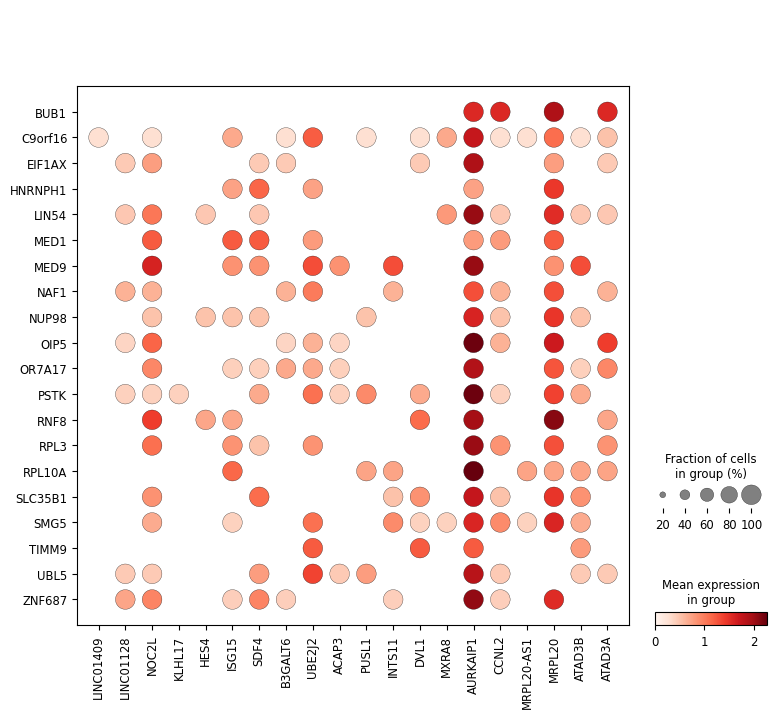

In [16]:
genes_of_interest = adata.var_names[:20] 

# Group by the column in adata.obs (e.g., 'condition' or 'guide_id')
#sc.pl.heatmap(adata, genes_of_interest, groupby='guide_id', cmap='viridis')
sc.pl.dotplot(adata[:20], genes_of_interest, groupby='perturbation')

## Reactome Map
For our world model we want to learn about pathways, not specific genes. As we increase data set variety and perturbation type, focusing on a model that understands pathway impact will allow us to better model different perturbations and understand their impact even if we aren't fully sure of the underlying mechanisms. Over time, this will also allow us to derive new theories on mechanism of action. 

To get started we'll use the [Drug Signatures Database (DSigDB)](https://academic.oup.com/bioinformatics/article/31/18/3069/241009) dataset mainly because it has a nice view of the different gene sets that relate drugs/compounds and their target genes.  This will give us a detailed, close to up to date, starting point to work backwards from.  

The dataset we're using is a fairly simple dictionary: it uses the pathway name as the key and then has the gene abbreviation in the items. 


Other datasets
* RummaGEO_GenePerturbations_2025 - 7961
* PerturbAtlas - 7741
* DSigDB - 7540

In [17]:
gs_res = gp.get_library(name='DSigDB', organism='Human')

In [18]:
gs_res['epinephrine']

['VDR',
 'KDM4E',
 'RECQL',
 'ADRA2C',
 'MTOR',
 'ADRA2B',
 'ADRA2A',
 'MAPT',
 'APEX1',
 'TDP1',
 'CYP1A2',
 'GAPDH',
 'NFE2L2',
 'FEN1',
 'ADRB1',
 'ADRB2',
 'ADRA1D',
 'ADRB3',
 'HIF1A',
 'ADRA1B',
 'ADRA1A',
 'HSD17B10',
 'CA1',
 'CA4',
 'POLK',
 'DRD1',
 'CA14']

Some regulatory pathways are quite sizeable and others very tiny. Also our DB has a lot of pathways: 4007. Longer term we'd want to include all these pathways, but for now, we want to try to keep long-tails out of our dataset.  If we look at the distribution of genes in each network we see a long top tail.  We'll go ahead and clip the top off to prevent this long tail.  We'll arbitrarily pick all the pathways with more than 80 and less than 1400 genes given that leads to covering most of the genes that we have expression data for without going too wide on our pathway counts. 

In [19]:
len(gs_res.keys())

4007

(array([3606.,  198.,   88.,   41.,   23.,   12.,   20.,    8.,    6.,
           5.]),
 array([  11. ,  205.7,  400.4,  595.1,  789.8,  984.5, 1179.2, 1373.9,
        1568.6, 1763.3, 1958. ]),
 <BarContainer object of 10 artists>)

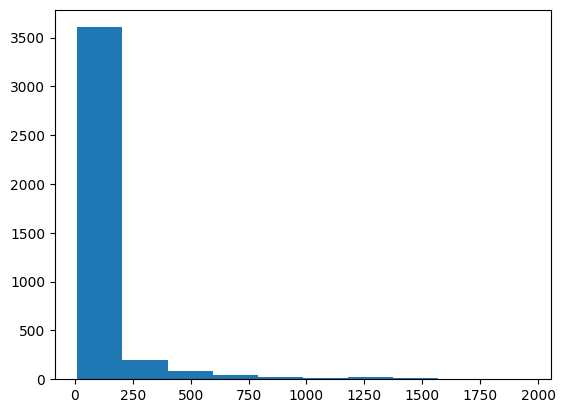

In [20]:
plt.hist([len(v) for k,v in gs_res.items()])

(array([655., 149.,  82.,  47.,  31.,  18.,  15.,   6.,  10.,  16.]),
 array([  80.,  209.,  338.,  467.,  596.,  725.,  854.,  983., 1112.,
        1241., 1370.]),
 <BarContainer object of 10 artists>)

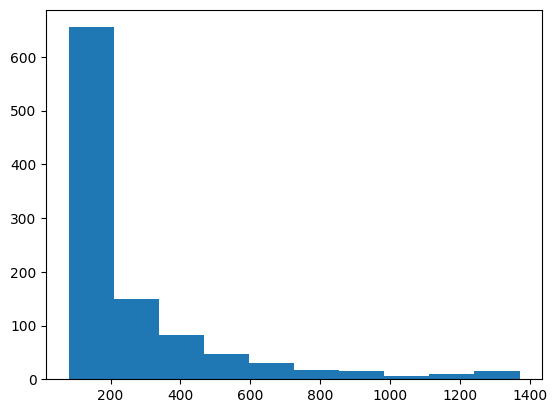

In [21]:
plt.hist([len(v) for k,v in gs_res.items() if 80 <= len(v) <= 1400])

In [22]:
valid_pathways = {k: v for k, v in gs_res.items() if 80 <= len(v) <= 1400}
len(list(valid_pathways.keys())), n_pathways

(1029, 1024)

We can see that even with cutting off the top tail we're still above our target, so we'll arbitrarily just select the first set up to our target number. 

In [23]:
selected_keys = list(valid_pathways.keys())[:n_pathways]
pathway_names = selected_keys
len(pathway_names)

1024

**Compare pathways and expression data for overlap**

We'll now see how many of our total genes we have in our reactome dataset. Recall that we started with 8563

In [24]:
reactome_genes = set(list(sum([v for k, v in valid_pathways.items() if k in selected_keys],[])))
len(reactome_genes)

17137

In [25]:
# genes we have expression for and reactome information for 
f'originally {len(set(genes))} but after {len(set(genes)) - len(set(genes) - reactome_genes)}'

'originally 8563 but after 7356'

## Gene to Network Encoding

Now that we have our gene regulatory network extracted, we want to create an encoding of which genes belong to which networks. To create an array that's workable we'll use normalized multi-hot encoding where we create a row for each gene, a column for each network, flag each gene in the network, and divide it by the total genes in the network.  As a result we get a  matrix similar to the following: 

$$
\begin{bmatrix}
.5 & .33 & 0 & .25 & 0 \\
0 & .33 & 0 & .25 & .5 \\
0 & .33 & 0 & .25 & .5 \\
.5 & 0 & 1 & .25 & 0
\end{bmatrix}_{gene \times network}
$$


First we'll go through a single example, then we'll create a loop to do all of the networks. We'll first start out by setting up an array of zeros to act as placeholders and a dictionary of our genes so that each network indexs the same gene in the same row. 

In [26]:
gene_mask = np.zeros((len(genes), len(selected_keys)), dtype=np.float32)
gene_to_idx = {gene: i for i, gene in enumerate(genes)}

#### Single Example

For our single example, we'll go ahead and pull out our first  network and hard code a 0 (first index).  This pathway is linked to Clotrimazole, a broad-spectrum antifungal medication.

In [27]:
p_idx, p_name = 0, selected_keys[0]
p_idx, p_name

(0, 'clotrimazole')

Next we'll index out the different genes in this pathway.  We can see that there's 87 different genes in this pathway 

In [28]:
genes_in_pathway = valid_pathways[p_name]
len(genes_in_pathway), genes_in_pathway

(87,
 ['KDM4A',
  'SLC12A5',
  'HSP90AA1',
  'JUN',
  'AVPR2',
  'GPR55',
  'CBX1',
  'OPRM1',
  'TACR1',
  'TACR2',
  'PPP1CA',
  'CYP2C9',
  'ADORA2A',
  'CYP1A2',
  'CDK1',
  'KCNK3',
  'NFE2L2',
  'RAPGEF4',
  'TP53',
  'ACHE',
  'CHRM3',
  'CHRM4',
  'ABCB1',
  'CHRM1',
  'CHRM2',
  'OPRD1',
  'GLP1R',
  'NR1I3',
  'HTR2C',
  'ADRB1',
  'ADRB2',
  'AHR',
  'HTR2A',
  'ADRA1D',
  'ADRB3',
  'CYP3A4',
  'HTR2B',
  'HSPB1',
  'CA2',
  'HRH2',
  'ATXN2',
  'HRH1',
  'CYSLTR1',
  'THPO',
  'CYP2D6',
  'CFL1',
  'ADORA3',
  'DRD1',
  'ADORA1',
  'DRD2',
  'DRD3',
  'DRD4',
  'CCR4',
  'KCNH2',
  'NPSR1',
  'CYP51A1',
  'OPRK1',
  'NR1H4',
  'ESR1',
  'ADRA2B',
  'ADRA2A',
  'TSHR',
  'AR',
  'KCNQ1',
  'TBXAS1',
  'TDP1',
  'PPARG',
  'PPARD',
  'GMNN',
  'PTAFR',
  'BAZ2B',
  'HIF1A',
  'SLC6A2',
  'CYP2C19',
  'HTR6',
  'NR3C1',
  'SLC6A3',
  'CYP19A1',
  'SLC6A4',
  'PTGS2',
  'CYP17A1',
  'TRPM2',
  'CXCR1',
  'MAPK1',
  'FYN',
  'KCNN4',
  'CYTH2'])

**Normalized multi-hot encoding**

Now that we have the genes, we'll go through each gene, see if it appears in our expression matrix list `gene_to_idx`.  If it does, we'll add a `1` to that row index and increment our hit.  Once we've gone through all the genes, we'll then divide the total by the number of hits we found so that the total weight equals to 1.0.  This ensure that large networks do not have overweighted impact in our training data compared to smaller networks.   

Interestingly you'll see that of the 87 genes in the network, only 20 show up in our perturbSeq data. As we generalize out this architecture, we'd want to make sure all 25K genes (or more depending on which DB is used) are represented, along with non gene compounds.  

In [29]:
hit_count = 0
for g in genes_in_pathway:
    if g in gene_to_idx:
        gene_mask[gene_to_idx[g], p_idx] = 1.0
        hit_count += 1
        
if hit_count > 0:
    print(f'hits {hit_count}')
    gene_mask[:, p_idx] /= hit_count
        

hits 20


Now let's index out one of the hits `KDM4A` and see that it matches what we expect, 1/20 or ~ 0.05. 

In [30]:
1/20, gene_mask[gene_to_idx['KDM4A'],0]

(0.05, np.float32(0.05))

#### Batch Run

Now that we've done it for the first pathway, to save time/space we'll run this for all the 1024 networks we've filtered to.  We'll reinitialize our gene mask and run it for all the genes. We have a message that tells us if a pathway only had 1 or 0 gene hits in it. This would tell us that likely that pathway is too sparse in our training and potentially should be filtered.  Eventually we'll add automated filtering into our data prep once we have it dialed in. 

In [31]:
gene_mask = np.zeros((len(genes), len(selected_keys)), dtype=np.float32)
for p_idx, p_name in enumerate(selected_keys):
    genes_in_pathway = valid_pathways[p_name]
    hit_count = 0
    for g in genes_in_pathway:
        if g in gene_to_idx:
            gene_mask[gene_to_idx[g], p_idx] = 1.0
            hit_count += 1
    
    # Normalize
    if hit_count > 1:
        gene_mask[:, p_idx] /= hit_count
    else:
        # early flag that a pathway didn't get hits
        print(f'pathway {p_name} had {hit_count} gene hits')

Even though we didn't see any messages print out, let's run a quick sanity check to ensure we truely don't have any empty pathways. 

In [32]:
np.where(np.all(gene_mask == 0, axis=0) == True)

(array([], dtype=int64),)

Finally, we'll go ahead and cache our pathway name to ID mappings so that if we needed to run this again or augment our data we don't have to process all of our examples from scratch. 

In [33]:
# Save Pathway Names for analysis later
with open(data_dir /'pathway_names.json', 'w') as f:
    json.dump(selected_keys, f)

## Create Case/Control Pairs

Now that we have our pathways, we'll actually need to create our case control pairing.  Our desired output is to be able to take the expression data from a perturbed (case) cell, pair it with a control cell from the same batch, map their impact from the gene expression level to the gene network level.  Roughly speaking we'll take the dot product of the network maps we just built and the gene expression information to create the network impact for the cell.  This is very rough since it'll basically just sum up all the expression information for a cell but it's a starting point to be improved upon later.  Roughly speaking we'll do the following: 

$$
\begin{bmatrix}
0 & .384 & 0 & .785 \\
0 & 0 & 0 & 1.542 \\
.234 & .183 & .421 & .248
\end{bmatrix}_{cell \times gene}
\cdot
\begin{bmatrix}
.5 & .33 & 0 & .25 & 0 \\
0 & .33 & 0 & .25 & .5 \\
0 & .33 & 0 & .25 & .5 \\
.5 & 0 & 1 & .25 & 0
\end{bmatrix}_{gene \times network}
=
\begin{bmatrix}
0.39 & 0.13 & 0.79 & 0.29 & 0.19 \\
0.77 & 0 & 1.54 & 0.39 & 0 \\
0.24 & 0.28 & 0.25 & 0.27 & 0.30
\end{bmatrix}_{cell \times network}
$$
					
				
				
					

After we have the network impact for the case and control, we'll save an identifier of the perturbation, the case, and the control together.  An example of the data to save would be: 
```
{
    'control':[array of network expression information],
    'perturbed':[array of network expression information],
    'action_ids':[id of the perturbation]
}
```

To achieve this, we'll first process the controls since that data is way smaller.  We'll then process the cases in the same way, pluck out the control that matches, and cache the data into numpy zip files so that we can process them in batches during training.

Similar to before, we'll walk through an example first, then do the batch processing. 

### Control Encoding. 

Let's start with the control. Recall that a batch can have multiple cotrol cells so we'll need to process the whole control batch at a time.  We'll start by creating a list of just the control cells.

In [34]:
is_control = adata.obs[COL_PERTURBATION].str.contains(COL_CONTROL_LABEL, case=False, na=False)
control_indices = np.where(is_control)[0]
adata.obs[is_control].head() # shows only true

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGAGGAG-47,47,non-targeting,non-targeting,non-targeting,11059_non-targeting_non-targeting_non-targeting,non-targeting_02010|non-targeting_01147,0.092709,12221.0,1.096669,0.600264,...,53,control,human,CRISPR,cell_line,12045.0,3265,0,0.280282,3265
AAACCCAAGCGTCTGC-27,27,non-targeting,non-targeting,non-targeting,11020_non-targeting_non-targeting_non-targeting,non-targeting_01763|non-targeting_02345,0.087307,14638.0,0.760877,0.813253,...,53,control,human,CRISPR,cell_line,14483.0,3916,0,0.204516,3916
AAACCCAAGGAGGGTG-47,47,non-targeting,non-targeting,non-targeting,11097_non-targeting_non-targeting_non-targeting,non-targeting_02274|non-targeting_01075,0.144649,11241.0,0.813080,0.600264,...,53,control,human,CRISPR,cell_line,11118.0,2999,0,0.239701,2999
AAACCCAAGTACCCTA-20,20,non-targeting,non-targeting,non-targeting,11320_non-targeting_non-targeting_non-targeting,non-targeting_03721|non-targeting_02172,0.101813,20302.0,1.392648,1.030337,...,53,control,human,CRISPR,cell_line,20073.0,4177,0,0.248991,4177
AAACCCAAGTGTTCAC-3,3,non-targeting,non-targeting,non-targeting,10969_non-targeting_non-targeting_non-targeting,non-targeting_01395|non-targeting_02523,0.085352,16098.0,0.087551,1.112076,...,53,control,human,CRISPR,cell_line,15898.0,3987,0,0.247578,3987


#### Single Example

Let's first pull out the first entry index and expression data from our filtered down controls.

In [35]:
idx_chunk = control_indices[0]
idx_chunk

np.int64(31)

In [36]:
raw_chunk = adata[idx_chunk].X
raw_chunk = raw_chunk.toarray()
raw_chunk

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 8563), dtype=float32)

**Network Impact**

Now that we have the expression infromation for our first control cell, we need to convert it to a network level impact map. We do this by taking the dot product of the expression information and our network map we made.  This takes our `[1,8563]` expression informaiton and converts it down to the 1024 networks.    

In [37]:
tokens_chunk = np.dot(raw_chunk, gene_mask) #(N, Pathways)
tokens_chunk.size, tokens_chunk

(1024,
 array([[0.59535915, 0.502429  , 0.44418362, ..., 0.35570267, 0.2023695 ,
         0.4333203 ]], shape=(1, 1024), dtype=float32))

**Append Batch Info**

Now that we have our network impact, we need to save it for the batch.  We'll extract the batch ID from the control cell metadata.  We'll then create an entry in our collection for the batch ID and append the network impact array to it.  We have to append to the collection entry since we have more than one control cell for a batch. 

In [38]:
batch_ids = adata.obs.iloc[[idx_chunk]][COL_BATCH].values
batch_ids

array([47])

In [39]:
control_cache = collections.defaultdict(list)
for b_id, tok in zip(batch_ids, tokens_chunk):
        control_cache[b_id].append(tok)

print(control_cache)

defaultdict(<class 'list'>, {np.int64(47): [array([0.59535915, 0.502429  , 0.44418362, ..., 0.35570267, 0.2023695 ,
       0.4333203 ], shape=(1024,), dtype=float32)]})


#### Batch Run

Now that we've done it for the first Control, to save time/space we'll run this for all 10,691 control cells we have. We'll reinitialize our collection and run it for all the cells. To speed this along we'll also run it in batches of 10 cells at a time.  Based on the dataset size and resource constraints we can increase or decrease the batch size.   

In [40]:
control_cache = collections.defaultdict(list)
batch_size = 10
for i in tqdm(range(0, len(control_indices), batch_size), desc='Tokenizing Controls'):
    idx_chunk = control_indices[i : i+batch_size]
    
    # Load Raw Genes
    # Note: Indexing backed anndata with list is slower, but acceptable for 200k cells
    # Optimization: If sorted, it's faster.
    raw_chunk = adata[idx_chunk].X
    raw_chunk = raw_chunk.toarray()
    
    # Tokenize
    tokens_chunk = np.dot(raw_chunk, gene_mask) #(N, Pathways)
    
    # Group by Batch
    batch_ids = adata.obs.iloc[idx_chunk][COL_BATCH].values
    
    for b_id, tok in zip(batch_ids, tokens_chunk):
        control_cache[b_id].append(tok)

# Convert lists to numpy arrays for fast sampling
for k in control_cache:
    control_cache[k] = np.array(control_cache[k])

Tokenizing Controls: 100%|█████████████████| 1070/1070 [00:04<00:00, 257.99it/s]


**Sanity Check** Now that we've extracted all the batches, let's ensure that our collection is indeed as long as the unique batches that we have in our raw data.  

In [41]:
len(set(adata.obs.iloc[control_indices].batch)) == len(control_cache.keys())

True

### Create a pair of the control and case

Now that we've processed our controls, we need to process our controls and cache our tokenized data. In this process we extract a pertrubed cell, we encode it's perturbation, we calculate it's network impact the same way we did the control, we pull a control example randomly from the same batch, and then we save the data for use later.  

Once again i'll go through one example and then run the process in large batches.  

Let's get started first by discovering which cells are our case. *Note* that here we start using the word "case" to indicate our perturbed cells. 

In [42]:
case_indices = np.where(~is_control)[0]
n_case = len(case_indices)
n_case

299694

#### Single Example

Let's first pull out the first entry from our perturbed cells. Lucky for us it's the very first entry of the dataset.  After we have it we'll also extract it's expression data 

In [43]:
idx_chunk = case_indices[0]
idx_chunk

np.int64(0)

In [44]:
chunk_adata = adata[idx_chunk]
X_case = chunk_adata.X
X_case = X_case.toarray()
X_case

array([[0.       , 0.6329088, 0.6329088, ..., 0.       , 0.       ,
        0.       ]], shape=(1, 8563), dtype=float32)

**Network Impact**

Now that we have the expression infromation for our first case cell, we need to convert it to a network level impact map. This is done the same way we processed the controls: We take the dot product of the expression information and our network map we made.  This again takes our `[1,8563]` expression informaiton and converts it down to the 1024 networks.    

In [45]:
tokens_case = np.dot(X_case, gene_mask)
tokens_case

array([[0.64809936, 0.6197561 , 0.64294475, ..., 0.32507715, 0.29266357,
        0.56609833]], shape=(1, 1024), dtype=float32)

**Encode Perturbation**

Next we'll need to convert the perturbation to an ID for training.  Recall that we created a dictionary earlier to map our gene perturbations to an integer.  We'll use our case cell's metadata to extract the perturbation and then use the dictionary to convert that into an ID. 

In [46]:
pert_names = chunk_adata.obs[COL_PERTURBATION].values
pert_ids = [pert_to_id[p] for p in pert_names]
pert_ids, pert_names

([0],
 ['NAF1']
 Categories (1, object): ['NAF1'])

**Link Control through Batch ID**

Now that we have our network impact and perturbation encoded, we need to get the batch ID so that we can then go to our collection and sample out  control cell to pair with our perturbed cell. We'll start by extracting the batch ID from the case cell's metadata. 

In [47]:
batch_ids = chunk_adata.obs[COL_BATCH].values 
batch_ids

array([27])

Now that we have our batch ID we need to extract a control cell for the batch. Recall that we created a collection (or dictionary) to store the controls by batch ID so we simply indext out the batch from that collection.  Once we have the controls for the batch, we are ready to sample an exmaple from the pool of controls. 

When we add other datasets, we'll need to make this more robust where, if there is not a perfect control for this specific batch, we'll either need to use another control from the dataset or a synthetic one for the lineage 

In [48]:
matched_controls = []
pool = control_cache[b_id]
len(pool), pool

(214,
 array([[0.684041  , 0.60310924, 0.55772763, ..., 0.37724897, 0.23412599,
         0.50900865],
        [0.71086043, 0.59351397, 0.5306915 , ..., 0.3636677 , 0.2771635 ,
         0.54880136],
        [0.82043535, 0.6700264 , 0.6188751 , ..., 0.38896772, 0.16397548,
         0.6143087 ],
        ...,
        [0.8692884 , 0.67592984, 0.6346323 , ..., 0.4050062 , 0.41086632,
         0.61994576],
        [0.8347172 , 0.64443004, 0.66166496, ..., 0.42504328, 0.23000407,
         0.6545032 ],
        [0.73848313, 0.61380565, 0.59689236, ..., 0.42056617, 0.3464403 ,
         0.5897176 ]], shape=(214, 1024), dtype=float32))

**Sampling a control**

Since we often have more than 1 control from the batch for our current dataset, we'll randomly sample from the control for our perturbation.  We happen to know that we don't have a perfect 1:1 mapping of control to perturbation, in fact we have way less controls, so our best bet is to randomly sample.  Other methods could be to create a mean control or some other average method, but for now we'll just use random sampling

In [49]:
rand_idx = np.random.randint(len(pool))
rand_idx

139

In [50]:
matched_controls.append(pool[rand_idx])
matched_controls = np.array(matched_controls)
matched_controls

array([[0.5428263 , 0.48084912, 0.55956274, ..., 0.29149547, 0.16823322,
        0.48417988]], shape=(1, 1024), dtype=float32)

**Creating the link**

Now that we have our perturbation encoding, our case cell network impact, and our control cell network impact, our next part would be to save a compressed file of the linkages.  Since this is just a single example, i'll create a dictionary example

In [51]:
{
    'control':matched_controls,
    'case':tokens_case,
    'action_ids':np.array(pert_ids, dtype=np.uint16)
}

{'control': array([[0.5428263 , 0.48084912, 0.55956274, ..., 0.29149547, 0.16823322,
         0.48417988]], shape=(1, 1024), dtype=float32),
 'case': array([[0.64809936, 0.6197561 , 0.64294475, ..., 0.32507715, 0.29266357,
         0.56609833]], shape=(1, 1024), dtype=float32),
 'action_ids': array([0], dtype=uint16)}

#### Batch Run

Now that we've walked through a single example, to save time/space we'll run this for all of the control cells we have. Since this will be our final finals used by our data loader for training, we want to make sure we create files that are at least as big as a batch but not too big to destory our memory when they're loaded. We'll start with an arbitrary 10K cells per file.  This corresponds to 10K case cells, their matched controls, and their perturbation embeddings. Depending on the training hardware and the tokenization you may need to change the chunk_size. 

In [52]:
buffer_control = []
buffer_case = []
buffer_actions = []

shard_counter = 0
chunk_size = 10000        # How many cells per .npy file

In [53]:
for i in tqdm(range(0, n_case, chunk_size), desc='Processing Pairs'):
    idx_chunk = case_indices[i : i+chunk_size]
    
    # Load Case Data
    chunk_adata = adata[idx_chunk]
    X_case = chunk_adata.X
    X_case = X_case.toarray()
    
    # Tokenize Case
    tokens_case = np.dot(X_case, gene_mask)
    
    # Get Metadata
    batch_ids = chunk_adata.obs[COL_BATCH].values 
    pert_names = chunk_adata.obs[COL_PERTURBATION].values
    pert_ids = [pert_to_id[p] for p in pert_names]
    
    # Find Pairs
    matched_controls = []
    for j, b_id in enumerate(batch_ids):
        # Try to find control from same batch
        if b_id in control_cache:
            pool = control_cache[b_id]
        else:
            # Fallback to any control if batch missing
            print(f'cannot find control for batch {b_id}')
            break
            # pool = control_cache[list(control_cache.keys())[0]]
        
        # Random Sample
        rand_idx = np.random.randint(len(pool))
        matched_controls.append(pool[rand_idx])
    
    matched_controls = np.array(matched_controls) # [Chunk, Pathways]
    
    # Save to buffers
    # Structure: [Control_Tokens (P), Case_Tokens (P), Action_ID (1)]
    # We save separate arrays to the shard for clarity
    
    np.savez_compressed(
        tokenized_dir/ f'shard_{shard_counter:04d}.npz',
        control=matched_controls,
        case=tokens_case,
        action_ids=np.array(pert_ids, dtype=np.uint16)
    )
    shard_counter += 1

Processing Pairs: 100%|█████████████████████████| 30/30 [01:18<00:00,  2.61s/it]
